# 台灣各縣市高齡人口與長照資源供需分析

## 一、研究背景與動機

### 研究背景
近年來，台灣快速邁入超高齡社會，高齡人口比例持續攀升。根據內政部人口統計，我國自民國109年起自然增加率轉為負值，顯示出生人口已無法支撐死亡人口，人口老化已成為不可逆的趨勢。

在高齡人口不斷成長的情況下，長期照顧需求急速擴張。政府推動長照2.0政策雖大幅擴增服務項目與供給量，但受限於地理分布、人口結構差異、偏鄉交通不便，以及各縣市老化速度不同，全國長照資源仍呈現供需不均與地區差異顯著的現象。

### 研究目的
本研究旨在透過完整的量化資料與統計方法，系統性檢驗台灣各縣市長照資源配置，達成以下目標：

1. **檢驗高齡化程度與長照資源配置的關係**
2. **評估長照資源配置對服務充足度之改善效果**
3. **探討地理因素對長照服務可近性的影響**
4. **提供政策建議與實務應用方向**

---

## 二、環境設定與資料準備

In [80]:
# =========================
# 套件導入 | Package Imports
# =========================

# 資料處理套件 | Data Processing
import pandas as pd
import numpy as np
import warnings

# 視覺化套件 | Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from math import pi

# 統計分析套件 | Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 地圖視覺化套件 | Map Visualization
import folium
from folium import plugins

# 系統工具 | System Tools
import os
import json

# 設定 | Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ 套件導入完成 | Packages imported successfully")

✓ 套件導入完成 | Packages imported successfully


In [81]:
# =========================
# 中文字型設定 | Chinese Font Configuration
# =========================

print("正在設定中文字型 | Configuring Chinese fonts...")

# 設定字型路徑 | Set font path
noto_font_dir = './fonts/Noto_Sans_TC/static'

if os.path.exists(noto_font_dir):
    font_files = {
        'Regular': os.path.join(noto_font_dir, 'NotoSansTC-Regular.ttf'),
        'Bold': os.path.join(noto_font_dir, 'NotoSansTC-Bold.ttf'),
        'Medium': os.path.join(noto_font_dir, 'NotoSansTC-Medium.ttf')
    }
    
    # 載入字型檔案 | Load font files
    for weight, font_path in font_files.items():
        if os.path.exists(font_path):
            font_manager.fontManager.addfont(font_path)
            print(f"  ✓ 已載入字型 | Font loaded: {weight}")
    
    # 設定 matplotlib 字型 | Configure matplotlib fonts
    plt.rcParams['font.sans-serif'] = ['Noto Sans TC', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    print("✓ 字型設定完成 | Font configuration completed")
else:
    print("⚠ 字型資料夾不存在，使用系統預設字型 | Font folder not found, using system default")
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang TC', 'Heiti TC']
    plt.rcParams['axes.unicode_minus'] = False

# 設定 seaborn 主題 | Set seaborn theme
sns.set_theme(style='whitegrid', font='Noto Sans TC')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("\n中文測試 | Chinese test: 台灣長照資源分析 ✓")

正在設定中文字型 | Configuring Chinese fonts...
  ✓ 已載入字型 | Font loaded: Regular
  ✓ 已載入字型 | Font loaded: Bold
  ✓ 已載入字型 | Font loaded: Medium
✓ 字型設定完成 | Font configuration completed

中文測試 | Chinese test: 台灣長照資源分析 ✓


### 2.1 資料載入函數 | Data Loading Functions

In [82]:
def load_population_data(filepath):
    """
    載入並清理人口資料 | Load and clean population data
    
    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path
        
    返回 | Returns:
        pd.DataFrame: 清理後的人口資料 | Cleaned population data
    """
    print(f"載入人口資料 | Loading population data: {filepath}")
    
    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding='utf-8')
    
    # 清理欄位名稱 | Clean column names
    df.columns = df.columns.str.strip()
    
    # 定義數值欄位 | Define numeric columns
    numeric_cols = ['總人口', '65～69', '70～74', '75～79', '80～84', 
                    '85～89', '90～94', '95～99', '100以上', '65以下']
    
    # 清理數值欄位：移除千分位符號、空白 | Clean numeric fields: remove commas and spaces
    for col in numeric_cols:
        if col in df.columns:
            df[col] = (df[col].astype(str)
                      .str.replace(',', '')
                      .str.replace(' ', '')
                      .astype(float))
    
    # 清理縣市名稱 | Clean city names
    df['區域別'] = df['區域別'].str.strip()
    
    # 計算65歲以上人口 | Calculate elderly population (65+)
    age_cols = ['65～69', '70～74', '75～79', '80～84', 
                '85～89', '90～94', '95～99', '100以上']
    df['65歲以上'] = df[age_cols].sum(axis=1)
    
    # 計算老年人口比例 | Calculate elderly population ratio
    df['老年人口比例(%)'] = (df['65歲以上'] / df['總人口']) * 100
    
    print(f"  ✓ 資料筆數 | Records: {len(df)}")
    print(f"  ✓ 縣市數量 | Cities: {df['區域別'].nunique()}")
    print(f"  ✓ 年份範圍 | Year range: {df['年份'].min()}-{df['年份'].max()}")
    
    return df


def load_ltc_data(filepath):
    """
    載入並清理長照據點資料 | Load and clean long-term care (LTC) facility data
    
    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path
        
    返回 | Returns:
        pd.DataFrame: 清理後的長照據點資料 | Cleaned LTC data
    """
    print(f"載入長照據點資料 | Loading LTC data: {filepath}")
    
    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding='utf-8')
    
    # 建立縣市代碼對照表 | Create city code mapping
    city_code_mapping = {
        '63000': '台北市', '64000': '高雄市', '65000': '新北市', '66000': '台中市',
        '67000': '台南市', '68000': '桃園市', '10002': '宜蘭縣', '10004': '新竹縣',
        '10005': '苗栗縣', '10007': '彰化縣', '10008': '南投縣', '10009': '雲林縣',
        '10010': '嘉義縣', '10013': '屏東縣', '10014': '台東縣', '10015': '花蓮縣',
        '10016': '澎湖縣', '10017': '基隆市', '10018': '新竹市', '10020': '嘉義市',
        '09007': '連江縣', '09020': '金門縣'
    }
    
    # 清理縣市代碼 | Clean city codes
    df['縣市代碼'] = df['縣市'].astype(str).str.strip().str.replace('"', '')
    df['縣市名稱'] = df['縣市代碼'].map(city_code_mapping)
    
    # 清理據點類型 | Clean facility types
    df['據點類型'] = df['O_ABC'].astype(str).str.strip().str.replace('"', '')
    
    # 過濾有效資料 | Filter valid data
    df_valid = df[(df['縣市名稱'].notna()) & 
                  (df['據點類型'].isin(['A', 'B', 'C']))].copy()
    
    print(f"  ✓ 有效據點數 | Valid facilities: {len(df_valid)}")
    print(f"  ✓ 據點類型分布 | Facility type distribution:")
    print(df_valid['據點類型'].value_counts().to_string())
    
    return df_valid


def load_area_data(filepath, target_year=113):
    """
    載入並清理土地面積資料 | Load and clean land area data
    
    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path
        target_year (int): 目標年份 | Target year
        
    返回 | Returns:
        pd.DataFrame: 清理後的面積資料 | Cleaned area data
    """
    print(f"載入土地面積資料 | Loading area data: {filepath}")
    
    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding='utf-8')
    
    # 清理縣市名稱 | Clean city names
    df['縣市'] = (df['縣市'].str.strip()
                 .str.replace(' ', '')
                 .str.replace('　', ''))
    
    # 清理面積數值 | Clean area values
    df['土地面積'] = (df['土地面積'].astype(str)
                    .str.replace(',', '')
                    .str.replace(' ', '')
                    .astype(float))
    
    # 篩選目標年份 | Filter target year
    df_year = df[df['年份'] == target_year]
    
    # 彙總各縣市總面積 | Aggregate total area by city
    city_area = (df_year.groupby('縣市')['土地面積']
                .sum()
                .reset_index())
    city_area.columns = ['縣市名稱', '土地面積(km²)']
    
    print(f"  ✓ 縣市數量 | Cities: {len(city_area)}")
    print(f"  ✓ 總面積 | Total area: {city_area['土地面積(km²)'].sum():.2f} km²")
    
    return city_area

print("✓ 資料載入函數定義完成 | Data loading functions defined")

✓ 資料載入函數定義完成 | Data loading functions defined


### 2.2 資料合併函數 | Data Merging Function

In [83]:
def merge_all_data(df_pop, df_ltc, df_area, target_year=113):
    """
    合併所有資料來源 | Merge all data sources
    
    參數 | Parameters:
        df_pop (pd.DataFrame): 人口資料 | Population data
        df_ltc (pd.DataFrame): 長照據點資料 | LTC data
        df_area (pd.DataFrame): 土地面積資料 | Area data
        target_year (int): 目標年份 | Target year
        
    返回 | Returns:
        pd.DataFrame: 合併後的完整資料 | Merged complete dataset
    """
    print(f"\n合併資料 | Merging data for year {target_year}...")
    
    # 彙總長照據點數 | Aggregate LTC facilities
    ltc_by_city = (df_ltc.groupby(['縣市名稱', '據點類型'])
                   .size()
                   .unstack(fill_value=0))
    ltc_by_city['總據點數'] = ltc_by_city.sum(axis=1)
    ltc_by_city = ltc_by_city.reset_index()
    
    # 篩選目標年份人口資料 | Filter population data for target year
    df_year = df_pop[df_pop['年份'] == target_year].copy()
    df_year['縣市名稱'] = df_year['區域別'].str.replace(' ', '')
    
    # 合併資料 | Merge datasets
    df_merged = df_year.merge(ltc_by_city, on='縣市名稱', how='left')
    df_merged = df_merged.merge(df_area, on='縣市名稱', how='left')
    
    # 填補缺失值 | Fill missing values
    facility_cols = ['A', 'B', 'C', '總據點數']
    df_merged[facility_cols] = df_merged[facility_cols].fillna(0)
    
    # 計算衍生指標 | Calculate derived indicators
    df_merged['人口密度(人/km²)'] = df_merged['總人口'] / df_merged['土地面積(km²)']
    df_merged['每千位高齡人口據點數'] = (df_merged['總據點數'] / df_merged['65歲以上']) * 1000
    df_merged['每平方公里據點數'] = df_merged['總據點數'] / df_merged['土地面積(km²)']
    
    print(f"  ✓ 合併完成 | Merge completed")
    print(f"  ✓ 最終資料筆數 | Final records: {len(df_merged)}")
    print(f"  ✓ 欄位數 | Columns: {len(df_merged.columns)}")
    
    return df_merged

print("✓ 資料合併函數定義完成 | Data merging function defined")

✓ 資料合併函數定義完成 | Data merging function defined


### 2.3 資料來源視覺化 | Data Source Visualization

繪製台灣各縣市長照ABC據點分布地圖，以及據點數量統計圖表。

In [84]:
# =========================
# 建立台灣各縣市長照據點分布地圖 | Create Taiwan LTC Facilities Distribution Map
# =========================

def create_taiwan_ltc_map(df_ltc, df_merged):
    """
    建立台灣長照據點分布地圖 | Create Taiwan LTC facilities distribution map
    
    參數 | Parameters:
        df_ltc: 長照據點原始資料 | Raw LTC data
        df_merged: 合併後的完整資料 | Merged complete data
    """
    
    # 建立台灣地圖中心點 | Set Taiwan map center
    taiwan_center = [23.5, 121.0]
    
    # 建立基礎地圖 | Create base map
    m = folium.Map(
        location=taiwan_center,
        zoom_start=7,
        tiles='OpenStreetMap'
    )
    
    # 定義縣市座標 (用於圓形標記) | Define city coordinates for circle markers
    city_coords = {
        '台北市': [25.0330, 121.5654],
        '新北市': [25.0120, 121.4659],
        '桃園市': [24.9937, 121.3010],
        '台中市': [24.1477, 120.6736],
        '台南市': [22.9998, 120.2269],
        '高雄市': [22.6273, 120.3014],
        '基隆市': [25.1276, 121.7392],
        '新竹市': [24.8138, 120.9675],
        '新竹縣': [24.8387, 121.0177],
        '苗栗縣': [24.5602, 120.8214],
        '彰化縣': [24.0518, 120.5161],
        '南投縣': [23.9609, 120.9719],
        '雲林縣': [23.7092, 120.4313],
        '嘉義市': [23.4801, 120.4491],
        '嘉義縣': [23.4518, 120.2554],
        '屏東縣': [22.5519, 120.5487],
        '宜蘭縣': [24.7021, 121.7377],
        '花蓮縣': [23.9871, 121.6015],
        '台東縣': [22.7972, 121.0713],
        '澎湖縣': [23.5712, 119.5793],
        '金門縣': [24.4489, 118.3765],
        '連江縣': [26.1605, 119.9495]
    }
    
    # 彙總各縣市據點統計 | Aggregate facility statistics by city
    city_stats = df_merged[['縣市名稱', 'A', 'B', 'C', '總據點數', '65歲以上', '每千位高齡人口據點數']].copy()
    
    # 定義顏色映射 (根據據點密度) | Define color mapping based on facility density
    max_density = city_stats['每千位高齡人口據點數'].max()
    min_density = city_stats['每千位高齡人口據點數'].min()
    
    def get_color(density):
        """根據據點密度返回顏色 | Return color based on density"""
        if pd.isna(density) or not np.isfinite(density):
            return 'gray'
        elif density > max_density * 0.7:
            return 'green'
        elif density > max_density * 0.4:
            return 'orange'
        else:
            return 'red'
    
    # 在地圖上標記各縣市據點 | Mark facilities on map
    for city, coords in city_coords.items():
        city_data = city_stats[city_stats['縣市名稱'] == city]
        
        if len(city_data) > 0:
            row = city_data.iloc[0]
            
            # 建立彈出視窗內容 | Create popup content
            popup_html = f"""
            <div style="font-family: 'Noto Sans TC', sans-serif; width: 200px;">
                <h4 style="margin: 0 0 10px 0; color: #2c3e50;">{city}</h4>
                <table style="width: 100%; border-collapse: collapse;">
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;"><b>總據點數</b></td>
                        <td style="padding: 5px; text-align: right;">{int(row['總據點數'])}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;">　A級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row['A'])}</td>
                    </tr>
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;">　B級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row['B'])}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;">　C級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row['C'])}</td>
                    </tr>
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;"><b>65歲以上人口</b></td>
                        <td style="padding: 5px; text-align: right;">{int(row['65歲以上']):,}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;"><b>每千位據點數</b></td>
                        <td style="padding: 5px; text-align: right;">{row['每千位高齡人口據點數']:.2f}</td>
                    </tr>
                </table>
            </div>
            """
            
            # 計算圓圈大小 (根據總據點數) | Calculate circle size based on total facilities
            radius = np.sqrt(row['總據點數']) * 2000
            
            # 決定顏色 | Determine color
            color = get_color(row['每千位高齡人口據點數'])
            
            # 添加圓形標記 | Add circle marker
            folium.CircleMarker(
                location=coords,
                radius=min(radius/1000, 30),  # 限制最大半徑 | Limit max radius
                popup=folium.Popup(popup_html, max_width=300),
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.6,
                weight=2
            ).add_to(m)
            
            # 添加縣市標籤 | Add city label
            folium.Marker(
                location=coords,
                icon=folium.DivIcon(html=f"""
                    <div style="font-size: 10pt; color: black; font-weight: bold; 
                         text-shadow: 1px 1px 2px white, -1px -1px 2px white;">
                        {city}
                    </div>
                """)
            ).add_to(m)
    
    # 添加圖例 | Add legend
    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 220px; height: 180px; 
                background-color: white; z-index:9999; font-size:12px;
                border:2px solid grey; border-radius: 5px; padding: 10px;
                font-family: 'Noto Sans TC', sans-serif;">
        <h4 style="margin: 0 0 10px 0;">長照據點密度</h4>
        <p style="margin: 5px 0;">
            <i style="background: green; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            充足 (高密度)
        </p>
        <p style="margin: 5px 0;">
            <i style="background: orange; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            中等
        </p>
        <p style="margin: 5px 0;">
            <i style="background: red; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            不足 (低密度)
        </p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0; font-size: 10px;">
            ● 圓圈大小代表總據點數<br>
            ● 顏色代表每千位高齡人口據點數
        </p>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

print("✓ 地圖繪製函數定義完成 | Map plotting function defined")

✓ 地圖繪製函數定義完成 | Map plotting function defined


In [85]:
# =========================
# 繪製各縣市長照ABC據點數量堆疊長條圖 | Plot stacked bar chart of LTC ABC facilities
# =========================

def plot_ltc_facilities_by_city(df):
    """繪製各縣市長照ABC據點數量堆疊長條圖"""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # 排序資料 | Sort data
    df_sorted = df.sort_values('總據點數', ascending=True)
    
    # 準備資料 | Prepare data
    cities = df_sorted['縣市名稱']
    a_count = df_sorted['A']
    b_count = df_sorted['B']
    c_count = df_sorted['C']
    
    # 繪製堆疊長條圖 | Plot stacked bar chart
    bars1 = ax.barh(cities, a_count, label='A級據點', color='#1f77b4')
    bars2 = ax.barh(cities, b_count, left=a_count, label='B級據點', color='#ff7f0e')
    bars3 = ax.barh(cities, c_count, left=a_count+b_count, label='C級據點', color='#2ca02c')
    
    # 添加總數標籤 | Add total labels
    for i, (city, total) in enumerate(zip(cities, df_sorted['總據點數'])):
        ax.text(total + 5, i, f'{int(total)}', va='center', fontsize=9)
    
    ax.set_xlabel('據點數量', fontsize=12)
    ax.set_title('各縣市長照ABC據點數量分布（113年）', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

print("✓ 長條圖繪製函數定義完成 | Bar chart plotting function defined")

✓ 長條圖繪製函數定義完成 | Bar chart plotting function defined


### 2.4 執行資料載入與視覺化 | Execute Data Loading and Visualization

In [86]:
# =========================
# 載入資料 | Load Data
# =========================

# 載入人口資料 | Load population data
df_pop = load_population_data('程式用-縣市人口按性別及五齡組.csv')

# 載入長照據點資料 | Load LTC data
df_ltc = load_ltc_data('data/長照ABC據點.csv')

# 載入土地面積資料 | Load area data
df_area = load_area_data('data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv', target_year=113)

# 合併所有資料 | Merge all data
df = merge_all_data(df_pop, df_ltc, df_area, target_year=113)

print("\n" + "="*80)
print("資料載入完成 | Data loading completed")
print("="*80)
print(f"分析對象: {len(df)} 個縣市, 民國113年")
print(f"總欄位數: {len(df.columns)}")

載入人口資料 | Loading population data: 程式用-縣市人口按性別及五齡組.csv
  ✓ 資料筆數 | Records: 220
  ✓ 縣市數量 | Cities: 22
  ✓ 年份範圍 | Year range: 104-113
載入長照據點資料 | Loading LTC data: data/長照ABC據點.csv
  ✓ 有效據點數 | Valid facilities: 26469
  ✓ 據點類型分布 | Facility type distribution:
據點類型
B    21282
C     4208
A      979
載入土地面積資料 | Loading area data: data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv
  ✓ 縣市數量 | Cities: 22
  ✓ 總面積 | Total area: 36194.45 km²

合併資料 | Merging data for year 113...
  ✓ 合併完成 | Merge completed
  ✓ 最終資料筆數 | Final records: 22
  ✓ 欄位數 | Columns: 23

資料載入完成 | Data loading completed
分析對象: 22 個縣市, 民國113年
總欄位數: 23
  ✓ 有效據點數 | Valid facilities: 26469
  ✓ 據點類型分布 | Facility type distribution:
據點類型
B    21282
C     4208
A      979
載入土地面積資料 | Loading area data: data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv
  ✓ 縣市數量 | Cities: 22
  ✓ 總面積 | Total area: 36194.45 km²

合併資料 | Merging data for year 113...
  ✓ 合併完成 | Merge completed
  ✓ 最終資料筆數 | Final records: 22
  ✓ 欄位數 | Columns: 23

資料載入完成 | Data loading completed
分析對象: 22 個縣市, 民國113年
總欄位數: 23

In [87]:
# =========================
# 繪製台灣長照據點分布地圖 | Generate Taiwan LTC Facilities Distribution Map
# =========================

print("\n" + "=" * 80)
print("生成台灣各縣市長照ABC據點分布地圖")
print("Generating Taiwan LTC ABC Facilities Distribution Map")
print("=" * 80)

# 建立地圖 | Create map
taiwan_map = create_taiwan_ltc_map(df_ltc, df)

# 儲存地圖為HTML檔案 | Save map as HTML file
map_filename = 'taiwan_ltc_map.html'
taiwan_map.save(map_filename)

print(f"\n✓ 地圖已生成並儲存為 {map_filename}")
print(f"✓ Map generated and saved as {map_filename}")
print("\n📍 圖例說明:")
print("  • 圓圈大小 = 總據點數量")
print("  • 綠色 = 資源充足 (高密度)")
print("  • 橘色 = 資源中等")
print("  • 紅色 = 資源不足 (低密度)")
print("  • 點擊各縣市可查看詳細資訊")

# 顯示地圖 | Display map
taiwan_map


生成台灣各縣市長照ABC據點分布地圖
Generating Taiwan LTC ABC Facilities Distribution Map

✓ 地圖已生成並儲存為 taiwan_ltc_map.html
✓ Map generated and saved as taiwan_ltc_map.html

📍 圖例說明:
  • 圓圈大小 = 總據點數量
  • 綠色 = 資源充足 (高密度)
  • 橘色 = 資源中等
  • 紅色 = 資源不足 (低密度)
  • 點擊各縣市可查看詳細資訊



繪製各縣市長照ABC據點數量統計圖


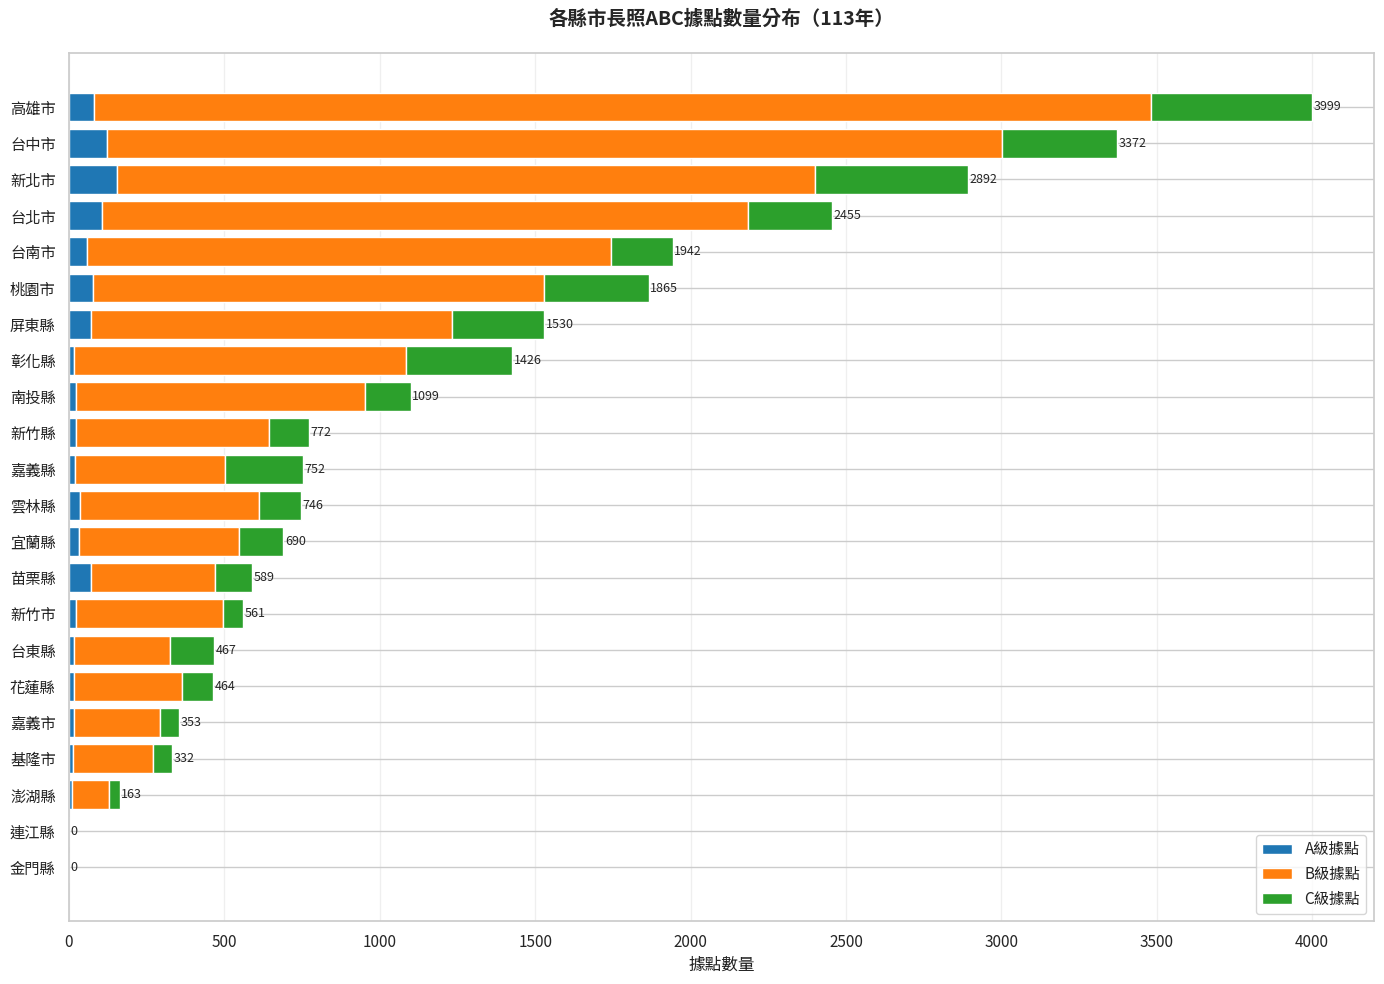


✓ 長條圖繪製完成


In [88]:
# =========================
# 繪製各縣市長照ABC據點數量堆疊長條圖 | Plot stacked bar chart
# =========================

print("\n" + "=" * 80)
print("繪製各縣市長照ABC據點數量統計圖")
print("=" * 80)

plot_ltc_facilities_by_city(df)

print("\n✓ 長條圖繪製完成")

---

## 三、統計分析方法 | Statistical Analysis Methods

本章節定義所有統計分析函數，包含：
1. 描述性統計分析
2. 皮爾森相關係數分析
3. 簡單線性迴歸
4. 服務密度分析
5. 供需落差分析
6. 多維度交叉比對分析

### 3.1 描述性統計分析函數 | Descriptive Statistics Function

In [89]:
def calculate_descriptive_stats(df):
    """
    計算描述性統計 | Calculate descriptive statistics
    """
    print("=" * 80)
    print("描述性統計分析 | Descriptive Statistics Analysis")
    print("=" * 80)
    
    results = {}
    
    # 高齡人口統計 | Elderly population statistics
    results['aging_stats'] = df[['縣市名稱', '總人口', '65歲以上', '老年人口比例(%)']].sort_values('老年人口比例(%)', ascending=False)
    results['avg_aging_rate'] = df['老年人口比例(%)'].mean()
    results['std_aging_rate'] = df['老年人口比例(%)'].std()
    
    # 長照據點統計 | LTC facility statistics
    results['ltc_stats'] = df[['縣市名稱', 'A', 'B', 'C', '總據點數']].sort_values('總據點數', ascending=False)
    results['total_facilities'] = df['總據點數'].sum()
    
    # 人口密度統計 | Population density statistics
    results['density_stats'] = df[['縣市名稱', '總人口', '土地面積(km²)', '人口密度(人/km²)']].sort_values('人口密度(人/km²)', ascending=False)
    results['avg_density'] = df['人口密度(人/km²)'].mean()
    
    return results


def calculate_correlation_analysis(df):
    """
    計算相關係數分析 | Calculate correlation analysis
    
    修正: 過濾 NaN 和無限值以避免計算錯誤
    """
    print("\n" + "=" * 80)
    print("相關係數分析 | Correlation Analysis")
    print("=" * 80)
    
    results = {}
    correlation_table = []
    
    # 變數對1：老年人口比例 vs 每千位高齡人口據點數
    valid_mask1 = df[['老年人口比例(%)', '每千位高齡人口據點數']].notna().all(axis=1) & \
                  np.isfinite(df['老年人口比例(%)']).values & \
                  np.isfinite(df['每千位高齡人口據點數']).values
    if valid_mask1.sum() > 2:
        r1, p1 = pearsonr(df.loc[valid_mask1, '老年人口比例(%)'], 
                          df.loc[valid_mask1, '每千位高齡人口據點數'])
        results['aging_vs_service'] = {'r': r1, 'p': p1, 'n': valid_mask1.sum()}
        correlation_table.append({
            '變數對': '老年人口比例(%) vs 每千位高齡人口據點數',
            '樣本數': valid_mask1.sum(),
            'Pearson r': f'{r1:.4f}',
            'p-value': f'{p1:.4f}',
            '顯著性': '**' if p1 < 0.01 else '*' if p1 < 0.05 else 'ns'
        })
        print(f"\n【變數對1】老年人口比例 vs 每千位高齡人口據點數")
        print(f"  有效樣本數 n = {valid_mask1.sum()}")
        print(f"  Pearson r = {r1:.4f}, p-value = {p1:.4f}")
    else:
        results['aging_vs_service'] = {'r': np.nan, 'p': np.nan, 'n': valid_mask1.sum()}
        print(f"\n【變數對1】⚠ 有效樣本數不足 (n={valid_mask1.sum()})")
    
    # 變數對2：人口密度 vs 每平方公里據點數
    valid_mask2 = df[['人口密度(人/km²)', '每平方公里據點數']].notna().all(axis=1) & \
                  np.isfinite(df['人口密度(人/km²)']).values & \
                  np.isfinite(df['每平方公里據點數']).values
    if valid_mask2.sum() > 2:
        r2, p2 = pearsonr(df.loc[valid_mask2, '人口密度(人/km²)'], 
                          df.loc[valid_mask2, '每平方公里據點數'])
        results['density_vs_spatial'] = {'r': r2, 'p': p2, 'n': valid_mask2.sum()}
        correlation_table.append({
            '變數對': '人口密度(人/km²) vs 每平方公里據點數',
            '樣本數': valid_mask2.sum(),
            'Pearson r': f'{r2:.4f}',
            'p-value': f'{p2:.4f}',
            '顯著性': '**' if p2 < 0.01 else '*' if p2 < 0.05 else 'ns'
        })
        print(f"\n【變數對2】人口密度 vs 每平方公里據點數")
        print(f"  有效樣本數 n = {valid_mask2.sum()}")
        print(f"  Pearson r = {r2:.4f}, p-value = {p2:.4f}")
    else:
        results['density_vs_spatial'] = {'r': np.nan, 'p': np.nan, 'n': valid_mask2.sum()}
        print(f"\n【變數對2】⚠ 有效樣本數不足 (n={valid_mask2.sum()})")
    
    # 變數對3：65歲以上人口 vs 總據點數
    valid_mask3 = df[['65歲以上', '總據點數']].notna().all(axis=1) & \
                  np.isfinite(df['65歲以上']).values & \
                  np.isfinite(df['總據點數']).values
    if valid_mask3.sum() > 2:
        r3, p3 = pearsonr(df.loc[valid_mask3, '65歲以上'], 
                          df.loc[valid_mask3, '總據點數'])
        results['elderly_vs_facilities'] = {'r': r3, 'p': p3, 'n': valid_mask3.sum()}
        correlation_table.append({
            '變數對': '65歲以上人口 vs 總據點數',
            '樣本數': valid_mask3.sum(),
            'Pearson r': f'{r3:.4f}',
            'p-value': f'{p3:.4f}',
            '顯著性': '**' if p3 < 0.01 else '*' if p3 < 0.05 else 'ns'
        })
        print(f"\n【變數對3】65歲以上人口 vs 總據點數")
        print(f"  有效樣本數 n = {valid_mask3.sum()}")
        print(f"  Pearson r = {r3:.4f}, p-value = {p3:.4f}")
    else:
        results['elderly_vs_facilities'] = {'r': np.nan, 'p': np.nan, 'n': valid_mask3.sum()}
        print(f"\n【變數對3】⚠ 有效樣本數不足 (n={valid_mask3.sum()})")
    
    # 儲存相關係數表格
    results['correlation_table'] = pd.DataFrame(correlation_table)
    
    return results


def calculate_regression_analysis(df):
    """
    計算迴歸分析 | Calculate regression analysis
    """
    print("\n" + "=" * 80)
    print("線性迴歸分析 | Linear Regression Analysis")
    print("=" * 80)
    
    results = {}
    
    # 模型1：老年人口比例 → 每千位高齡人口據點數
    X1 = df[['老年人口比例(%)']].values
    y1 = df['每千位高齡人口據點數'].values
    model1 = LinearRegression()
    model1.fit(X1, y1)
    y1_pred = model1.predict(X1)
    r2_1 = r2_score(y1, y1_pred)
    
    results['model1'] = {
        'coef': model1.coef_[0],
        'intercept': model1.intercept_,
        'r2': r2_1,
        'predictions': y1_pred
    }
    
    print(f"\n模型1: 每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例")
    print(f"  斜率 β₁ = {model1.coef_[0]:.4f}")
    print(f"  截距 β₀ = {model1.intercept_:.4f}")
    print(f"  R² = {r2_1:.4f}")
    
    # 模型2：65歲以上人口 → 總據點數
    X2 = df[['65歲以上']].values
    y2 = df['總據點數'].values
    model2 = LinearRegression()
    model2.fit(X2, y2)
    y2_pred = model2.predict(X2)
    r2_2 = r2_score(y2, y2_pred)
    
    results['model2'] = {
        'coef': model2.coef_[0],
        'intercept': model2.intercept_,
        'r2': r2_2,
        'predictions': y2_pred
    }
    
    print(f"\n模型2: 總據點數 = β₀ + β₁ × 65歲以上人口")
    print(f"  斜率 β₁ = {model2.coef_[0]:.6f}")
    print(f"  截距 β₀ = {model2.intercept_:.4f}")
    print(f"  R² = {r2_2:.4f}")
    
    return results


def calculate_supply_demand_gap(df):
    """
    計算供需落差 | Calculate supply-demand gap
    """
    print("\n" + "=" * 80)
    print("供需落差分析 | Supply-Demand Gap Analysis")
    print("=" * 80)
    
    # 計算全國平均服務率 | Calculate national average service rate
    avg_service_rate = df['每千位高齡人口據點數'].mean()
    
    # 計算所需據點數 | Calculate required facilities
    df['所需據點數'] = (df['65歲以上'] * avg_service_rate / 1000).round(0)
    df['服務缺口'] = df['所需據點數'] - df['總據點數']
    df['缺口比例(%)'] = (df['服務缺口'] / df['所需據點數'] * 100).round(2)
    
    print(f"\n合理服務標準: 每千位高齡人口 {avg_service_rate:.2f} 個據點")
    
    # 識別資源不足與充足區域 | Identify shortage and surplus areas
    shortage = df[df['服務缺口'] > 0].sort_values('服務缺口', ascending=False)
    surplus = df[df['服務缺口'] < 0].sort_values('服務缺口')
    
    results = {
        'avg_service_rate': avg_service_rate,
        'shortage_areas': shortage,
        'surplus_areas': surplus,
        'gap_data': df[['縣市名稱', '65歲以上', '總據點數', '所需據點數', '服務缺口', '缺口比例(%)']].copy()
    }
    
    print(f"\n資源不足區域: {len(shortage)} 個縣市")
    print(f"資源充足區域: {len(surplus)} 個縣市")
    
    return results


def identify_hotspots(df):
    """
    識別資源不足熱點 | Identify resource shortage hotspots
    """
    print("\n" + "=" * 80)
    print("資源不足熱點識別 | Hotspot Identification")
    print("=" * 80)
    
    # 計算Z分數 | Calculate Z-scores
    df['老化程度Z'] = (df['老年人口比例(%)'] - df['老年人口比例(%)'].mean()) / df['老年人口比例(%)'].std()
    df['資源充足度Z'] = (df['每千位高齡人口據點數'] - df['每千位高齡人口據點數'].mean()) / df['每千位高齡人口據點數'].std()
    
    # 計算優先設置分數 | Calculate priority score
    df['優先設置分數'] = df['老化程度Z'] - df['資源充足度Z']
    
    # 識別熱點 | Identify hotspots
    avg_aging = df['老年人口比例(%)'].mean()
    avg_resource = df['每千位高齡人口據點數'].mean()
    
    hotspots = df[
        (df['老年人口比例(%)'] > avg_aging) & 
        (df['每千位高齡人口據點數'] < avg_resource)
    ].sort_values('優先設置分數', ascending=False)
    
    results = {
        'hotspots': hotspots,
        'priority_ranking': df[['縣市名稱', '老年人口比例(%)', '每千位高齡人口據點數', '優先設置分數']].sort_values('優先設置分數', ascending=False),
        'avg_aging': avg_aging,
        'avg_resource': avg_resource
    }
    
    print(f"\n識別到 {len(hotspots)} 個資源不足熱點")
    
    return results

print("✓ 統計分析函數定義完成 | Statistical analysis functions defined")

✓ 統計分析函數定義完成 | Statistical analysis functions defined


---

## 四、執行分析 | Execute Analysis

載入資料並執行所有統計分析。

### 3.2 統計表格輸出函數 | Statistical Table Output Functions

In [90]:
def print_correlation_table(corr_results):
    """
    輸出表格:皮爾森相關係數分析統計表
    """
    print("\n" + "=" * 80)
    print("表一、皮爾森相關係數分析統計表")
    print("=" * 80)
    print()
    
    if 'correlation_table' in corr_results:
        df_corr = corr_results['correlation_table']
        display(df_corr)
        print("\n註:* p < 0.05, ** p < 0.01, ns = 不顯著")
    else:
        print("無相關係數數據")


def print_regression_table(reg_results, df):
    """
    輸出表格:迴歸統計表與ANOVA表
    """
    print("\n" + "=" * 80)
    print("表二、線性迴歸統計表 - 模型1")
    print("=" * 80)
    print("依變數:每千位高齡人口據點數")
    print("自變數:老年人口比例(%)")
    print()
    
    model1 = reg_results['model1']
    n = len(df)
    
    # 迴歸統計表
    regression_stats1 = pd.DataFrame({
        '統計量': ['Multiple R', 'R²', '調整後 R²', '標準誤', '觀察值個數'],
        '數值': [
            f"{np.sqrt(model1['r2']):.4f}",
            f"{model1['r2']:.4f}",
            f"{1 - (1-model1['r2'])*(n-1)/(n-2):.4f}",
            f"{np.sqrt(mean_squared_error(df['每千位高齡人口據點數'], model1['predictions'])):.4f}",
            f"{n}"
        ]
    })
    display(regression_stats1)
    
    # ANOVA表
    print("\n" + "-" * 80)
    print("表三、ANOVA表 - 模型1")
    print("-" * 80)
    print()
    
    SSR = np.sum((model1['predictions'] - df['每千位高齡人口據點數'].mean())**2)
    SSE = np.sum((df['每千位高齡人口據點數'] - model1['predictions'])**2)
    SST = SSR + SSE
    df_reg = 1
    df_res = n - 2
    MSR = SSR / df_reg
    MSE = SSE / df_res
    F = MSR / MSE
    
    anova_df1 = pd.DataFrame({
        '來源': ['迴歸', '殘差', '總和'],
        'df': [df_reg, df_res, n-1],
        'SS': [f'{SSR:.2f}', f'{SSE:.2f}', f'{SST:.2f}'],
        'MS': [f'{MSR:.2f}', f'{MSE:.2f}', ''],
        'F': [f'{F:.4f}', '', ''],
        '顯著性F': [f'{1 - stats.f.cdf(F, df_reg, df_res):.4f}', '', '']
    })
    display(anova_df1)
    
    # 係數表
    print("\n" + "-" * 80)
    print("表四、線性迴歸係數表 - 模型1")
    print("-" * 80)
    print()
    
    se_slope = np.sqrt(MSE / np.sum((df['老年人口比例(%)'] - df['老年人口比例(%)'].mean())**2))
    t_slope = model1['coef'] / se_slope
    p_slope = 2 * (1 - stats.t.cdf(abs(t_slope), df_res))
    
    coef_df1 = pd.DataFrame({
        '項目': ['截距', '老年人口比例(%)'],
        '係數': [f"{model1['intercept']:.4f}", f"{model1['coef']:.4f}"],
        '標準誤': ['', f'{se_slope:.4f}'],
        't統計': ['', f'{t_slope:.4f}'],
        'p-value': ['', f'{p_slope:.4f}']
    })
    display(coef_df1)
    
    # 模型2
    print("\n\n" + "=" * 80)
    print("表五、線性迴歸統計表 - 模型2")
    print("=" * 80)
    print("依變數:總據點數")
    print("自變數:65歲以上人口")
    print()
    
    model2 = reg_results['model2']
    
    regression_stats2 = pd.DataFrame({
        '統計量': ['Multiple R', 'R²', '調整後 R²', '標準誤', '觀察值個數'],
        '數值': [
            f"{np.sqrt(model2['r2']):.4f}",
            f"{model2['r2']:.4f}",
            f"{1 - (1-model2['r2'])*(n-1)/(n-2):.4f}",
            f"{np.sqrt(mean_squared_error(df['總據點數'], model2['predictions'])):.4f}",
            f"{n}"
        ]
    })
    display(regression_stats2)
    
    # 模型2 ANOVA
    print("\n" + "-" * 80)
    print("表六、ANOVA表 - 模型2")
    print("-" * 80)
    print()
    
    SSR2 = np.sum((model2['predictions'] - df['總據點數'].mean())**2)
    SSE2 = np.sum((df['總據點數'] - model2['predictions'])**2)
    SST2 = SSR2 + SSE2
    MSR2 = SSR2 / df_reg
    MSE2 = SSE2 / df_res
    F2 = MSR2 / MSE2
    
    anova_df2 = pd.DataFrame({
        '來源': ['迴歸', '殘差', '總和'],
        'df': [df_reg, df_res, n-1],
        'SS': [f'{SSR2:.2f}', f'{SSE2:.2f}', f'{SST2:.2f}'],
        'MS': [f'{MSR2:.2f}', f'{MSE2:.2f}', ''],
        'F': [f'{F2:.4f}', '', ''],
        '顯著性F': [f'{1 - stats.f.cdf(F2, df_reg, df_res):.4f}', '', '']
    })
    display(anova_df2)


def print_descriptive_table(desc_results, df):
    """
    輸出表格:各數值統計表
    """
    print("\n" + "=" * 80)
    print("表七、各縣市主要指標統計表")
    print("=" * 80)
    print()
    
    summary_cols = ['縣市名稱', '總人口', '65歲以上', '老年人口比例(%)', 
                    '總據點數', '每千位高齡人口據點數', '人口密度(人/km²)']
    
    display_df = df[summary_cols].copy()
    
    # 格式化數值欄位,但保持為數值類型以便表格呈現
    display_df['總人口'] = display_df['總人口'].astype(int)
    display_df['65歲以上'] = display_df['65歲以上'].astype(int)
    display_df['老年人口比例(%)'] = display_df['老年人口比例(%)'].round(2)
    display_df['總據點數'] = display_df['總據點數'].astype(int)
    display_df['每千位高齡人口據點數'] = display_df['每千位高齡人口據點數'].apply(
        lambda x: round(x, 2) if pd.notna(x) and np.isfinite(x) else np.nan
    )
    display_df['人口密度(人/km²)'] = display_df['人口密度(人/km²)'].apply(
        lambda x: round(x, 2) if pd.notna(x) and np.isfinite(x) else np.nan
    )
    
    display(display_df)

print("✓ 統計表格輸出函數定義完成 | Statistical table output functions defined")

✓ 統計表格輸出函數定義完成 | Statistical table output functions defined


In [91]:
# =========================
# 執行所有統計分析 | Execute All Statistical Analyses
# =========================

# 1. 描述性統計 | Descriptive statistics
desc_results = calculate_descriptive_stats(df)

# 2. 相關係數分析 | Correlation analysis
corr_results = calculate_correlation_analysis(df)

# 3. 迴歸分析 | Regression analysis
reg_results = calculate_regression_analysis(df)

# 4. 供需落差分析 | Supply-demand gap analysis
gap_results = calculate_supply_demand_gap(df)

# 5. 熱點識別 | Hotspot identification
hotspot_results = identify_hotspots(df)

# 儲存分析結果 | Save analysis results
analysis_results = {
    'descriptive': desc_results,
    'correlation': corr_results,
    'regression': reg_results,
    'gap': gap_results,
    'hotspots': hotspot_results,
    'data': df
}

print("\n" + "="*80)
print("✓ 所有統計分析完成 | All statistical analyses completed")
print("="*80)

描述性統計分析 | Descriptive Statistics Analysis

相關係數分析 | Correlation Analysis

【變數對1】老年人口比例 vs 每千位高齡人口據點數
  有效樣本數 n = 22
  Pearson r = 0.1535, p-value = 0.4953

【變數對2】人口密度 vs 每平方公里據點數
  有效樣本數 n = 18
  Pearson r = 0.9585, p-value = 0.0000

【變數對3】65歲以上人口 vs 總據點數
  有效樣本數 n = 22
  Pearson r = 0.9164, p-value = 0.0000

線性迴歸分析 | Linear Regression Analysis

模型1: 每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例
  斜率 β₁ = 0.1814
  截距 β₀ = 2.7808
  R² = 0.0236

模型2: 總據點數 = β₀ + β₁ × 65歲以上人口
  斜率 β₁ = 0.004771
  截距 β₀ = 229.7130
  R² = 0.8398

供需落差分析 | Supply-Demand Gap Analysis

合理服務標準: 每千位高齡人口 6.29 個據點

資源不足區域: 10 個縣市
資源充足區域: 12 個縣市

資源不足熱點識別 | Hotspot Identification

識別到 6 個資源不足熱點

✓ 所有統計分析完成 | All statistical analyses completed


### 4.1 輸出統計分析表格 | Output Statistical Analysis Tables

In [92]:
# =========================
# 輸出統計表格 | Output Statistical Tables
# =========================

# 表一: 皮爾森相關係數分析統計表
print_correlation_table(corr_results)

# 表二至六: 迴歸統計表與ANOVA表
print_regression_table(reg_results, df)

# 表七: 各縣市主要指標統計表
print_descriptive_table(desc_results, df)


表一、皮爾森相關係數分析統計表



,變數對,樣本數,Pearson r,p-value,顯著性
0,老年人口比例(%) vs 每千位高齡人口據點數,22,0.1535,0.4953,ns
1,人口密度(人/km²) vs 每平方公里據點數,18,0.9585,0.0000,**
2,65歲以上人口 vs 總據點數,22,0.9164,0.0000,**



註:* p < 0.05, ** p < 0.01, ns = 不顯著

表二、線性迴歸統計表 - 模型1
依變數:每千位高齡人口據點數
自變數:老年人口比例(%)



,統計量,數值
0,Multiple R,0.1535
1,R²,0.0236
2,調整後 R²,-0.0253
3,標準誤,2.7070
4,觀察值個數,22



--------------------------------------------------------------------------------
表三、ANOVA表 - 模型1
--------------------------------------------------------------------------------



,來源,df,SS,MS,F,顯著性F
0,迴歸,1,3.89,3.89,0.4824,0.4953
1,殘差,20,161.21,8.06,,
2,總和,21,165.10,,,



--------------------------------------------------------------------------------
表四、線性迴歸係數表 - 模型1
--------------------------------------------------------------------------------



,項目,係數,標準誤,t統計,p-value
0,截距,2.7808,,,
1,老年人口比例(%),0.1814,0.2612,0.6945,0.4953




表五、線性迴歸統計表 - 模型2
依變數:總據點數
自變數:65歲以上人口



,統計量,數值
0,Multiple R,0.9164
1,R²,0.8398
2,調整後 R²,0.8318
3,標準誤,437.5301
4,觀察值個數,22



--------------------------------------------------------------------------------
表六、ANOVA表 - 模型2
--------------------------------------------------------------------------------



,來源,df,SS,MS,F,顯著性F
0,迴歸,1,22078039.40,22078039.40,104.8460,0.0000
1,殘差,20,4211517.20,210575.86,,
2,總和,21,26289556.59,,,



表七、各縣市主要指標統計表



,縣市名稱,總人口,65歲以上,老年人口比例(%),總據點數,每千位高齡人口據點數,人口密度(人/km²)
0,新北市,4047001,768492,18.99,2892,3.76,1971.68
1,台北市,2490869,574458,23.06,2455,4.27,NaN
2,桃園市,2338648,371475,15.88,1865,5.02,1915.43
3,台中市,2860601,474248,16.58,3372,7.11,NaN
4,台南市,1858651,364115,19.59,1942,5.33,NaN
5,高雄市,2731412,544267,19.93,3999,7.35,925.24
6,宜蘭縣,449212,89618,19.95,690,7.70,209.56
7,新竹縣,594641,86088,14.48,772,8.97,416.55
8,苗栗縣,532854,104168,19.55,589,5.65,292.73
9,彰化縣,1225675,238924,19.49,1426,5.97,1140.80


---

## 五、結果視覺化 | Result Visualization

用圖表呈現分析結果。

In [93]:
# =========================
# 視覺化函數定義 | Visualization Functions
# =========================

def plot_aging_rate_by_city(df):
    """繪製各縣市老年人口比例長條圖 | Plot elderly population ratio by city"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    data = df.sort_values('老年人口比例(%)', ascending=True)
    avg = df['老年人口比例(%)'].mean()
    colors = ['#d62728' if x > avg else '#1f77b4' for x in data['老年人口比例(%)']]
    
    bars = ax.barh(data['縣市名稱'], data['老年人口比例(%)'], color=colors)
    ax.axvline(x=avg, color='red', linestyle='--', linewidth=2, label=f'全國平均 ({avg:.2f}%)')
    
    ax.set_xlabel('老年人口比例 (%)', fontsize=12)
    ax.set_title('各縣市老年人口比例（113年）', fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, val in zip(bars, data['老年人口比例(%)']):
        ax.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()


def plot_service_gap(df):
    """繪製各縣市服務缺口長條圖 | Plot service gap by city"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    data = df.sort_values('服務缺口', ascending=True)
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in data['服務缺口']]
    
    bars = ax.barh(data['縣市名稱'], data['服務缺口'], color=colors)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    ax.set_xlabel('服務缺口（據點數）', fontsize=12)
    ax.set_title('各縣市長照服務缺口（113年）', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, val in zip(bars, data['服務缺口']):
        offset = 5 if val >= 0 else -5
        ha = 'left' if val >= 0 else 'right'
        ax.text(val + offset, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                va='center', ha=ha, fontsize=9)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d62728', label='資源不足'),
        Patch(facecolor='#2ca02c', label='資源充足')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=11)
    
    plt.tight_layout()
    plt.show()


def plot_scatter_analysis(df):
    """繪製散佈圖分析 | Plot scatter analysis"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    avg_aging = df['老年人口比例(%)'].mean()
    avg_resource = df['每千位高齡人口據點數'].mean()
    
    scatter = ax.scatter(
        df['老年人口比例(%)'], 
        df['每千位高齡人口據點數'], 
        s=df['65歲以上']/5000, 
        alpha=0.6, 
        c=df['服務缺口'], 
        cmap='RdYlGn_r', 
        edgecolors='black', 
        linewidth=0.5
    )
    
    # 添加縣市標籤 | Add city labels
    for idx, row in df.iterrows():
        ax.annotate(
            row['縣市名稱'], 
            (row['老年人口比例(%)'], row['每千位高齡人口據點數']),
            xytext=(5, 5), 
            textcoords='offset points', 
            fontsize=9,
            alpha=0.8
        )
    
    # 添加平均線 | Add average lines
    ax.axhline(y=avg_resource, color='blue', linestyle='--', alpha=0.5, 
               label=f'資源平均 ({avg_resource:.2f})')
    ax.axvline(x=avg_aging, color='red', linestyle='--', alpha=0.5, 
               label=f'老化平均 ({avg_aging:.2f}%)')
    
    # 標註四個象限 | Label four quadrants
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[1]-1, ylim[1]-0.5, '高老化\n高資源', fontsize=11, ha='right', color='green', fontweight='bold')
    ax.text(xlim[0]+0.5, ylim[1]-0.5, '低老化\n高資源', fontsize=11, ha='left', color='blue', fontweight='bold')
    ax.text(xlim[1]-1, ylim[0]+0.5, '高老化\n低資源\n(熱點)', fontsize=11, ha='right', color='red', fontweight='bold')
    ax.text(xlim[0]+0.5, ylim[0]+0.5, '低老化\n低資源', fontsize=11, ha='left', color='gray', fontweight='bold')
    
    ax.set_xlabel('老年人口比例 (%)', fontsize=12)
    ax.set_ylabel('每千位高齡人口據點數', fontsize=12)
    ax.set_title('老年人口比例 vs 長照資源密度（氣泡大小=高齡人口數）', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('服務缺口', fontsize=11)
    
    plt.tight_layout()
    plt.show()

print("✓ 視覺化函數定義完成 | Visualization functions defined")

✓ 視覺化函數定義完成 | Visualization functions defined


In [94]:
def plot_regression_analysis(df, reg_results):
    """
    繪製迴歸分析圖表 | Plot regression analysis with scatter plot and regression line
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 圖1:模型1 - 老年人口比例 vs 每千位高齡人口據點數
    ax1 = axes[0]
    model1 = reg_results['model1']
    
    # 散佈圖
    ax1.scatter(df['老年人口比例(%)'], df['每千位高齡人口據點數'], 
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    
    # 迴歸線
    x_line = np.linspace(df['老年人口比例(%)'].min(), df['老年人口比例(%)'].max(), 100)
    y_line = model1['intercept'] + model1['coef'] * x_line
    ax1.plot(x_line, y_line, 'r-', linewidth=2, 
            label=f'迴歸線: y = {model1["intercept"]:.2f} + {model1["coef"]:.2f}x')
    
    # 添加縣市標籤
    for idx, row in df.iterrows():
        ax1.annotate(row['縣市名稱'], 
                    (row['老年人口比例(%)'], row['每千位高齡人口據點數']),
                    xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)
    
    ax1.set_xlabel('老年人口比例 (%)', fontsize=11)
    ax1.set_ylabel('每千位高齡人口據點數', fontsize=11)
    ax1.set_title(f'模型1:線性迴歸分析\nR² = {model1["r2"]:.4f}', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 圖2:模型2 - 65歲以上人口 vs 總據點數
    ax2 = axes[1]
    model2 = reg_results['model2']
    
    # 散佈圖
    ax2.scatter(df['65歲以上']/10000, df['總據點數'], 
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5, color='green')
    
    # 迴歸線
    x_line2 = np.linspace(df['65歲以上'].min(), df['65歲以上'].max(), 100)
    y_line2 = model2['intercept'] + model2['coef'] * x_line2
    ax2.plot(x_line2/10000, y_line2, 'r-', linewidth=2, 
            label=f'迴歸線: y = {model2["intercept"]:.2f} + {model2["coef"]:.4f}x')
    
    # 添加縣市標籤
    for idx, row in df.iterrows():
        ax2.annotate(row['縣市名稱'], 
                    (row['65歲以上']/10000, row['總據點數']),
                    xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)
    
    ax2.set_xlabel('65歲以上人口 (萬人)', fontsize=11)
    ax2.set_ylabel('總據點數', fontsize=11)
    ax2.set_title(f'模型2:線性迴歸分析\nR² = {model2["r2"]:.4f}', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ 迴歸分析視覺化函數定義完成 | Regression visualization function defined")

✓ 迴歸分析視覺化函數定義完成 | Regression visualization function defined


生成視覺化圖表 | Generating visualizations...



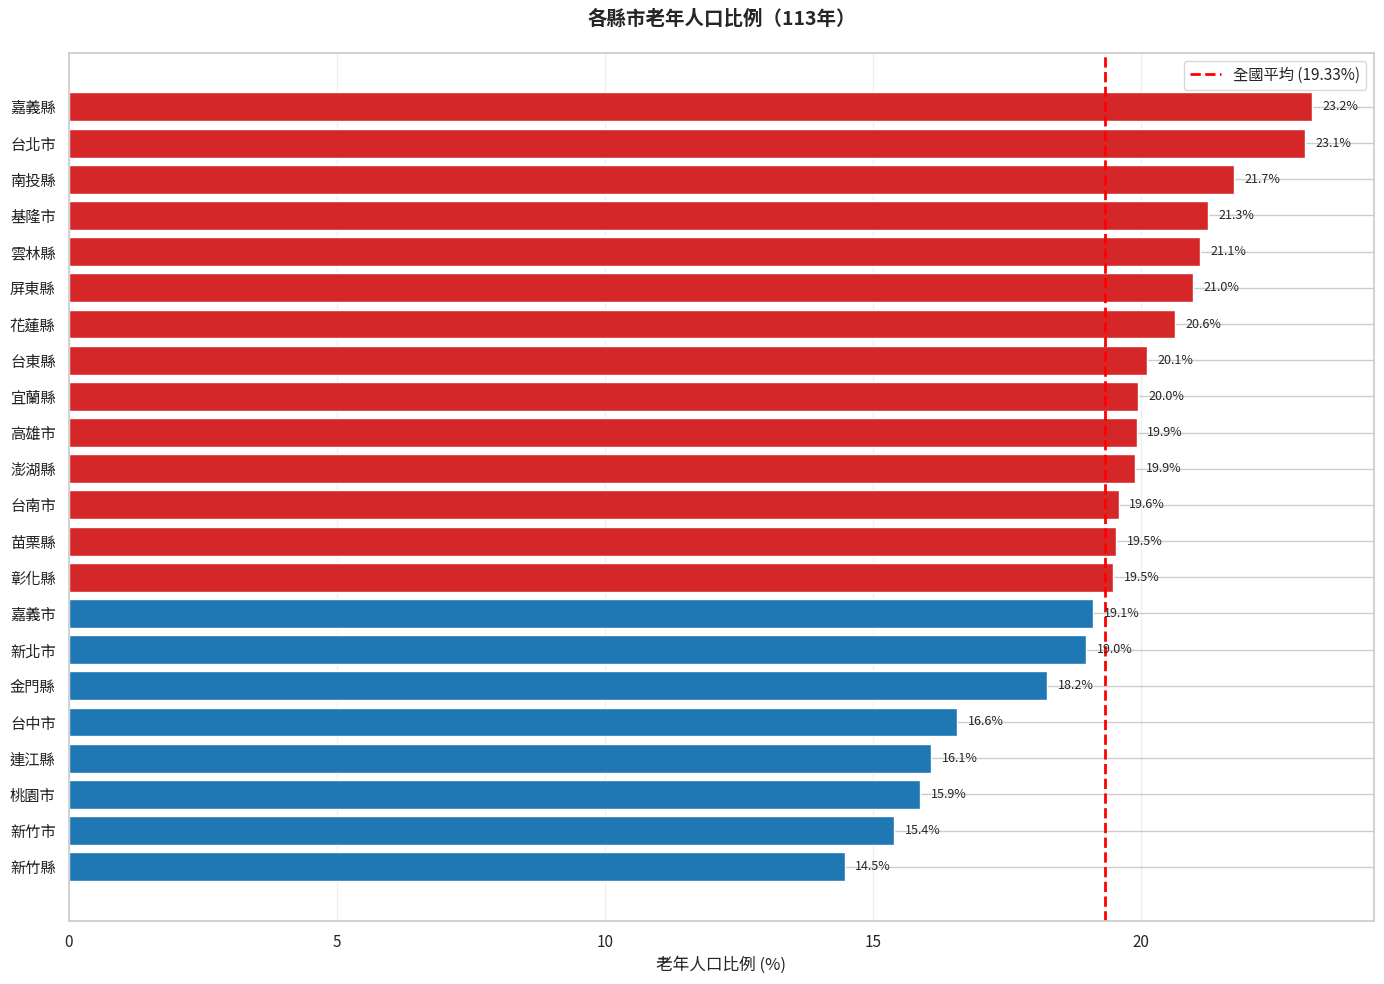

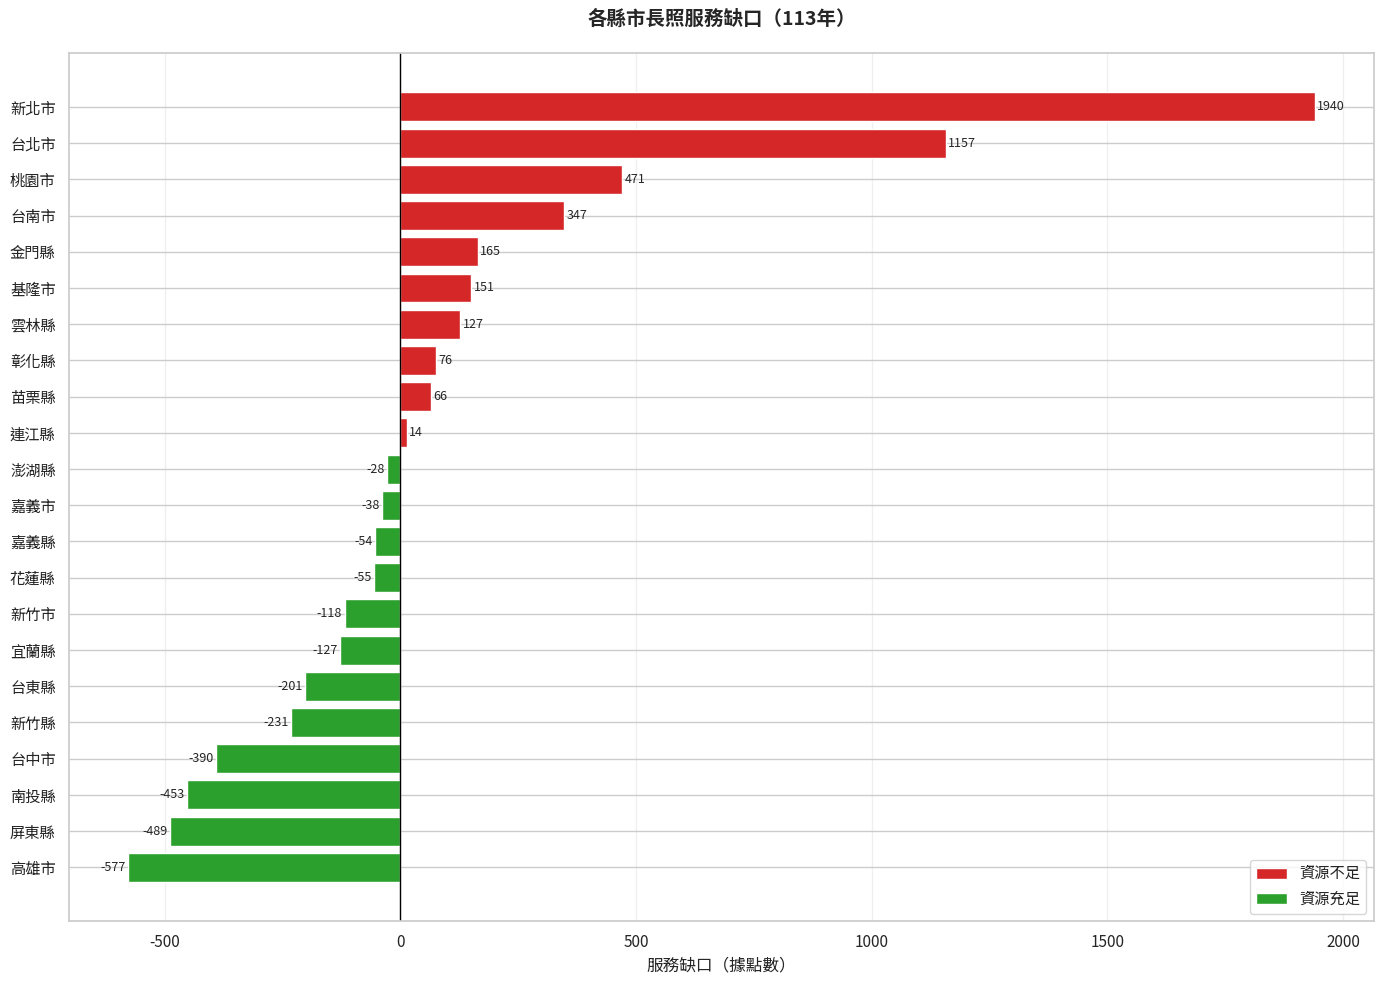

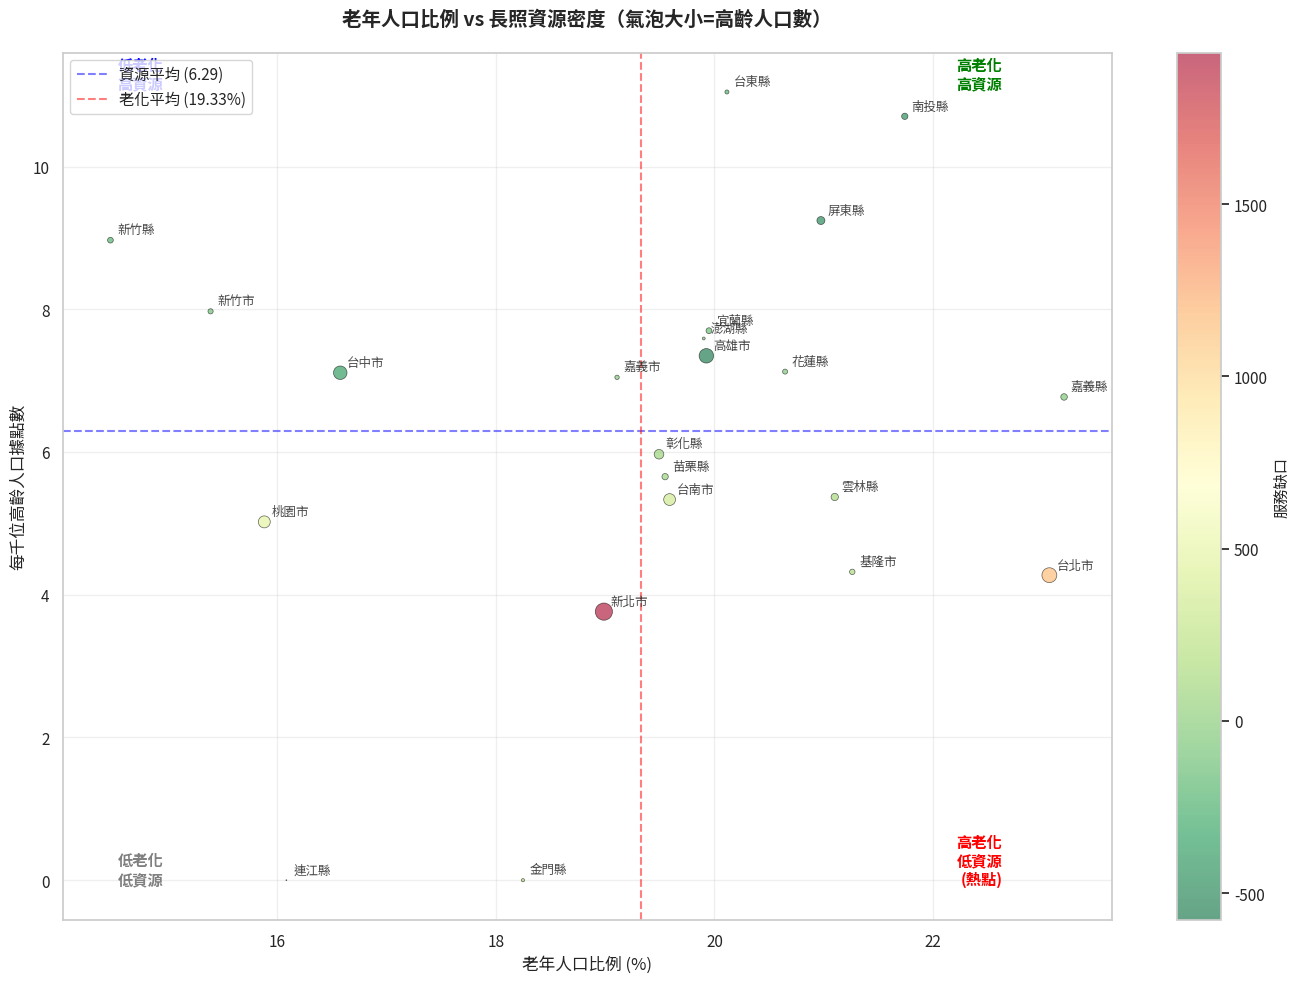


✓ 所有圖表生成完成 | All visualizations generated


In [95]:
# =========================
# 生成所有圖表 | Generate All Visualizations
# =========================

print("生成視覺化圖表 | Generating visualizations...\n")

# 圖表1：各縣市老年人口比例 | Elderly population ratio by city
plot_aging_rate_by_city(df)

# 圖表2：各縣市服務缺口 | Service gap by city
plot_service_gap(df)

# 圖表3：散佈圖分析 | Scatter plot analysis
plot_scatter_analysis(df)

print("\n✓ 所有圖表生成完成 | All visualizations generated")


生成迴歸分析視覺化 | Generating regression analysis visualizations...



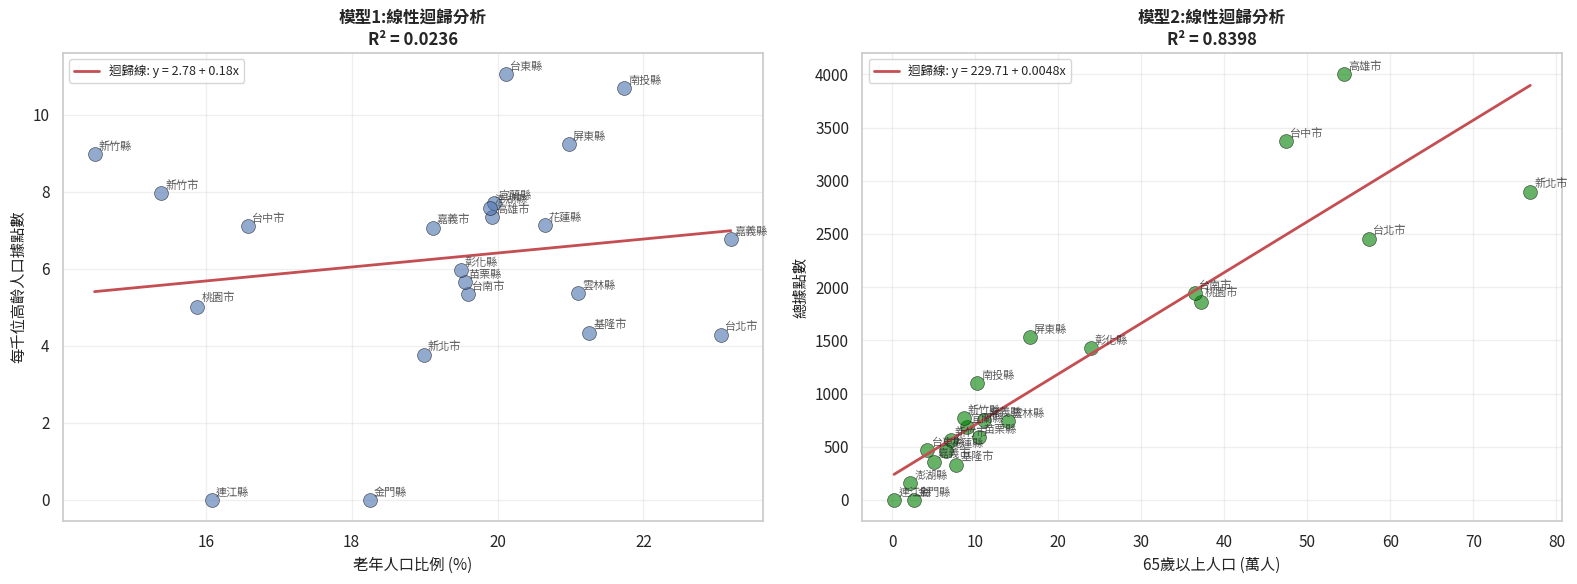


✓ 迴歸分析圖表生成完成 | Regression analysis plots generated


In [96]:
# =========================
# 生成迴歸分析圖表 | Generate Regression Analysis Plots
# =========================

print("\n生成迴歸分析視覺化 | Generating regression analysis visualizations...\n")

# 迴歸分析散佈圖與迴歸線
plot_regression_analysis(df, reg_results)

print("\n✓ 迴歸分析圖表生成完成 | Regression analysis plots generated")

---

## 六、研究結果與討論 | Results and Discussion

### 6.1 描述性統計結果摘要

In [97]:
# =========================
# 輸出描述性統計摘要 | Output Descriptive Statistics Summary
# =========================

print("=" * 80)
print("描述性統計結果摘要 | Descriptive Statistics Summary")
print("=" * 80)

print("\n【一、整體概況】")
print(f"分析年份: 113年")
print(f"縣市數量: {len(df)} 個")
print(f"全國高齡人口: {df['65歲以上'].sum():,.0f} 人")
print(f"全國平均老年人口比例: {desc_results['avg_aging_rate']:.2f}%")
print(f"全國長照據點總數: {desc_results['total_facilities']:.0f} 個")

print("\n【二、老化程度分析】")
top3_aging = df.nlargest(3, '老年人口比例(%)')
print("老化程度最高前三名：")
for i, row in enumerate(top3_aging.iterrows(), 1):
    print(f"  {i}. {row[1]['縣市名稱']}: {row[1]['老年人口比例(%)']:.2f}%")

print("\n【三、長照資源分布】")
top3_facilities = df.nlargest(3, '總據點數')
print("長照據點最多前三名：")
for i, row in enumerate(top3_facilities.iterrows(), 1):
    print(f"  {i}. {row[1]['縣市名稱']}: {row[1]['總據點數']:.0f} 個據點")

描述性統計結果摘要 | Descriptive Statistics Summary

【一、整體概況】
分析年份: 113年
縣市數量: 22 個
全國高齡人口: 4,488,707 人
全國平均老年人口比例: 19.33%
全國長照據點總數: 26469 個

【二、老化程度分析】
老化程度最高前三名：
  1. 嘉義縣: 23.20%
  2. 台北市: 23.06%
  3. 南投縣: 21.74%

【三、長照資源分布】
長照據點最多前三名：
  1. 高雄市: 3999 個據點
  2. 台中市: 3372 個據點
  3. 新北市: 2892 個據點


### 6.2 相關分析結果

In [98]:
# =========================
# 相關分析結果解讀 | Correlation Analysis Results Interpretation
# =========================

print("=" * 80)
print("相關分析結果解讀 | Correlation Analysis Interpretation")
print("=" * 80)

r1 = corr_results['aging_vs_service']['r']
p1 = corr_results['aging_vs_service']['p']
r2 = corr_results['density_vs_spatial']['r']
p2 = corr_results['density_vs_spatial']['p']
r3 = corr_results['elderly_vs_facilities']['r']
p3 = corr_results['elderly_vs_facilities']['p']

def interpret_correlation(r):
    """解釋相關係數強度 | Interpret correlation strength"""
    abs_r = abs(r)
    if abs_r > 0.7:
        return "強相關"
    elif abs_r > 0.4:
        return "中度相關"
    else:
        return "弱相關"

print(f"\n【變數對1】老年人口比例 vs 每千位高齡人口據點數")
print(f"  Pearson r = {r1:.4f} ({interpret_correlation(r1)})")
print(f"  p-value = {p1:.4f} {'(顯著)' if p1 < 0.05 else '(不顯著)'}")
print(f"  解讀: {'老化程度' + ('越高' if r1 > 0 else '越低') + '，資源配置' + ('越多' if r1 > 0 else '越少')}")

print(f"\n【變數對2】人口密度 vs 每平方公里據點數")
print(f"  Pearson r = {r2:.4f} ({interpret_correlation(r2)})")
print(f"  p-value = {p2:.4f} {'(顯著)' if p2 < 0.05 else '(不顯著)'}")
print(f"  解讀: {'人口密度' + ('越高' if r2 > 0 else '越低') + '，空間資源密度' + ('越高' if r2 > 0 else '越低')}")

print(f"\n【變數對3】65歲以上人口 vs 總據點數")
print(f"  Pearson r = {r3:.4f} ({interpret_correlation(r3)})")
print(f"  p-value = {p3:.4f} {'(顯著)' if p3 < 0.05 else '(不顯著)'}")
print(f"  解讀: {'高齡人口' + ('越多' if r3 > 0 else '越少') + '，據點數量' + ('越多' if r3 > 0 else '越少')}")

相關分析結果解讀 | Correlation Analysis Interpretation

【變數對1】老年人口比例 vs 每千位高齡人口據點數
  Pearson r = 0.1535 (弱相關)
  p-value = 0.4953 (不顯著)
  解讀: 老化程度越高，資源配置越多

【變數對2】人口密度 vs 每平方公里據點數
  Pearson r = 0.9585 (強相關)
  p-value = 0.0000 (顯著)
  解讀: 人口密度越高，空間資源密度越高

【變數對3】65歲以上人口 vs 總據點數
  Pearson r = 0.9164 (強相關)
  p-value = 0.0000 (顯著)
  解讀: 高齡人口越多，據點數量越多


### 6.3 迴歸分析結果

In [99]:
# =========================
# 迴歸分析結果解讀 | Regression Analysis Results Interpretation
# =========================

print("=" * 80)
print("迴歸分析結果解讀 | Regression Analysis Interpretation")
print("=" * 80)

model1 = reg_results['model1']
model2 = reg_results['model2']

def interpret_r2(r2):
    """解釋R²值 | Interpret R² value"""
    if r2 > 0.7:
        return "解釋力強"
    elif r2 > 0.4:
        return "中等解釋力"
    else:
        return "解釋力弱"

print("\n【模型1】每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例")
print(f"  斜率 β₁ = {model1['coef']:.4f}")
print(f"  截距 β₀ = {model1['intercept']:.4f}")
print(f"  R² = {model1['r2']:.4f} ({interpret_r2(model1['r2'])})")
print(f"  解讀: 老年人口比例每增加1%，每千位高齡人口據點數{'增加' if model1['coef'] > 0 else '減少'}{abs(model1['coef']):.4f}個")

print("\n【模型2】總據點數 = β₀ + β₁ × 65歲以上人口")
print(f"  斜率 β₁ = {model2['coef']:.6f}")
print(f"  截距 β₀ = {model2['intercept']:.4f}")
print(f"  R² = {model2['r2']:.4f} ({interpret_r2(model2['r2'])})")
print(f"  解讀: 65歲以上人口每增加1萬人，據點數{'增加' if model2['coef'] > 0 else '減少'}{abs(model2['coef']*10000):.2f}個")

迴歸分析結果解讀 | Regression Analysis Interpretation

【模型1】每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例
  斜率 β₁ = 0.1814
  截距 β₀ = 2.7808
  R² = 0.0236 (解釋力弱)
  解讀: 老年人口比例每增加1%，每千位高齡人口據點數增加0.1814個

【模型2】總據點數 = β₀ + β₁ × 65歲以上人口
  斜率 β₁ = 0.004771
  截距 β₀ = 229.7130
  R² = 0.8398 (解釋力強)
  解讀: 65歲以上人口每增加1萬人，據點數增加47.71個


---

## 七、結論與政策建議 | Conclusions and Policy Recommendations

In [100]:
# =========================
# 政策建議報告 | Policy Recommendation Report
# =========================

print("=" * 80)
print("研究結論與政策建議")
print("RESEARCH CONCLUSIONS AND POLICY RECOMMENDATIONS")
print("=" * 80)

print("\n【一、研究發現 | Key Findings】")
print(f"1. 全國22縣市中，{len(gap_results['shortage_areas'])}個縣市資源不足")
print(f"2. 平均老年人口比例: {desc_results['avg_aging_rate']:.2f}%")
print(f"3. 全國長照據點總數: {desc_results['total_facilities']:.0f} 個")

if len(hotspot_results['hotspots']) > 0:
    print(f"4. 識別出 {len(hotspot_results['hotspots'])} 個資源不足熱點區域")
    
print("\n【二、資源不足熱點 | Resource Shortage Hotspots】")
if len(hotspot_results['hotspots']) > 0:
    print("需優先關注的區域:")
    for i, row in enumerate(hotspot_results['hotspots'].iterrows(), 1):
        city_data = row[1]
        print(f"  {i}. {city_data['縣市名稱']}")
        print(f"     - 老化率: {city_data['老年人口比例(%)']:.2f}%")
        print(f"     - 每千位高齡人口據點數: {city_data['每千位高齡人口據點數']:.2f}")
        print(f"     - 服務缺口: {city_data['服務缺口']:.0f} 個據點")
else:
    print("無明顯資源不足熱點")

print("\n【三、政策建議 | Policy Recommendations】")

# 建議1：優先設置據點的區域 | Priority areas for facility establishment
print("\n1. 優先設置長照據點的區域 (依優先順序):")
priority_top5 = hotspot_results['priority_ranking'].head(5)
for i, row in enumerate(priority_top5.iterrows(), 1):
    city_data = row[1]
    gap = df[df['縣市名稱'] == city_data['縣市名稱']]['服務缺口'].values[0]
    if gap > 0:
        print(f"   {i}. {city_data['縣市名稱']} - 建議增設 {gap:.0f} 個據點")

# 建議2：改善資源配置機制 | Improve resource allocation mechanism
print("\n2. 改善資源配置評估機制:")
print("   - 加入地理可近性指標 (考慮交通距離)")
print("   - 建立動態調整機制 (依人口變化調整)")
print("   - 強化偏鄉資源配置 (提高偏鄉配置標準)")

# 建議3：配套措施 | Supporting measures
print("\n3. 建議配套措施:")
print("   - 偏鄉交通補貼: 提供長照交通接送服務")
print("   - 人力資源培訓: 增加長照專業人員")
print("   - 科技輔助: 導入遠距照護系統")
print("   - 跨域合作: 整合醫療與長照資源")

# 建議4：未來研究方向 | Future research directions
print("\n4. 未來研究方向:")
print("   - 時間序列分析: 追蹤資源配置變化趨勢")
print("   - 服務品質評估: 納入使用者滿意度調查")
print("   - 成本效益分析: 評估資源配置效率")
print("   - 區域差異研究: 深入探討都市與偏鄉差異")

print("\n" + "=" * 80)
print("✓ 分析完成 | Analysis Completed")
print("=" * 80)

研究結論與政策建議
RESEARCH CONCLUSIONS AND POLICY RECOMMENDATIONS

【一、研究發現 | Key Findings】
1. 全國22縣市中，10個縣市資源不足
2. 平均老年人口比例: 19.33%
3. 全國長照據點總數: 26469 個
4. 識別出 6 個資源不足熱點區域

【二、資源不足熱點 | Resource Shortage Hotspots】
需優先關注的區域:
  1. 台北市
     - 老化率: 23.06%
     - 每千位高齡人口據點數: 4.27
     - 服務缺口: 1157 個據點
  2. 基隆市
     - 老化率: 21.26%
     - 每千位高齡人口據點數: 4.32
     - 服務缺口: 151 個據點
  3. 雲林縣
     - 老化率: 21.10%
     - 每千位高齡人口據點數: 5.37
     - 服務缺口: 127 個據點
  4. 台南市
     - 老化率: 19.59%
     - 每千位高齡人口據點數: 5.33
     - 服務缺口: 347 個據點
  5. 苗栗縣
     - 老化率: 19.55%
     - 每千位高齡人口據點數: 5.65
     - 服務缺口: 66 個據點
  6. 彰化縣
     - 老化率: 19.49%
     - 每千位高齡人口據點數: 5.97
     - 服務缺口: 76 個據點

【三、政策建議 | Policy Recommendations】

1. 優先設置長照據點的區域 (依優先順序):
   1. 台北市 - 建議增設 1157 個據點
   2. 金門縣 - 建議增設 165 個據點
   3. 基隆市 - 建議增設 151 個據點
   5. 雲林縣 - 建議增設 127 個據點

2. 改善資源配置評估機制:
   - 加入地理可近性指標 (考慮交通距離)
   - 建立動態調整機制 (依人口變化調整)
   - 強化偏鄉資源配置 (提高偏鄉配置標準)

3. 建議配套措施:
   - 偏鄉交通補貼: 提供長照交通接送服務
   - 人力資源培訓: 增加長照專業人員
   - 科技輔助: 導入遠距照護系統
   - 跨域合作: 整合醫療與長照資源